## Getting Started with Monte-Carlo

The Monte Carlo method is a statistical technique that involves running multiple simulations with randomly sampled input parameters to estimate the distribution of the output variables.

To get started with applying Monte-Carlo simulation to pypsa-earth energy modelling tool, in the `config.yaml` file, set `add_to_snakefile` to true in the monte_carlo section. This will enable the monte-carlo option.

- Choose the number of samples for the monte-carlo simulations.
- Select the sampling strategy to use from `chaospy`, `pydoe2`, or `scipy`.
- Set seed for reproducibility.

Under the `uncertainties` section, users can add flexibly features for the Monte-Carlo sampling using the description below
  - {pypsa network object, e.g. "loads_t.p_set"}:
  - type: {any distribution among: "uniform", "normal", "lognormal", "triangle", "beta" and "gamma"}
  - args: {arguments passed as a list depending on the distribution, see arguments description in Chaospy reference guide (https://chaospy.readthedocs.io/en/master/reference/distribution/index.html)}

This is an example of the monte-carlo options in the config file.

```python
monte_carlo:
  options:
    add_to_snakefile: true
    samples: 49 # number of optimizations. Note that number of samples when using scipy has to be the square of a prime number
    sampling_strategy: "chaospy"  # "pydoe2", "chaospy", "scipy", packages that are supported
    seed: 42 # set seedling for reproducibilty
  uncertainties:
    loads_t.p_set:
      type: normal
      args: [1, 100]
    generators_t.p_max_pu.loc[:, n.generators.carrier == "solar"]:
      type: uniform
      args: [0.1, 1]
    generators_t.p_max_pu.loc[:, n.generators.carrier == "onwind"]:
      type: lognormal
      args: [1.5]
    generators.capital_cost.loc[n.generators.carrier == "solar"]:
      type: triangle
      args: [0.7]
    generators.capital_cost.loc[n.generators.carrier == "onwind"]:
      type: beta
      args: [0.5, 1]
    generators.weight.loc[n.generators.carrier == "onwind"]:
      type: beta
      args: [2, 0.5]
    generators.weight.loc[n.generators.carrier == "solar"]:
      type: gamma
      args: [2, 0.5]
```

To generate a DAG for the Monte-Carlo workflow, run `snakemake -j1 solve_all_networks_monte --dag > workflow.dot`. This should create a `workflow.dot` file in your directory. 

Inspect the first line in the `workflow.dot` file, if the first line has something of this sort `Restricted license - for non-production use only - expires 2025-11-24`, then remove the first line. Then run `dot workflow.dot -Tpng -o workflow.png` to create a `png` file from `workflow.dot` file.

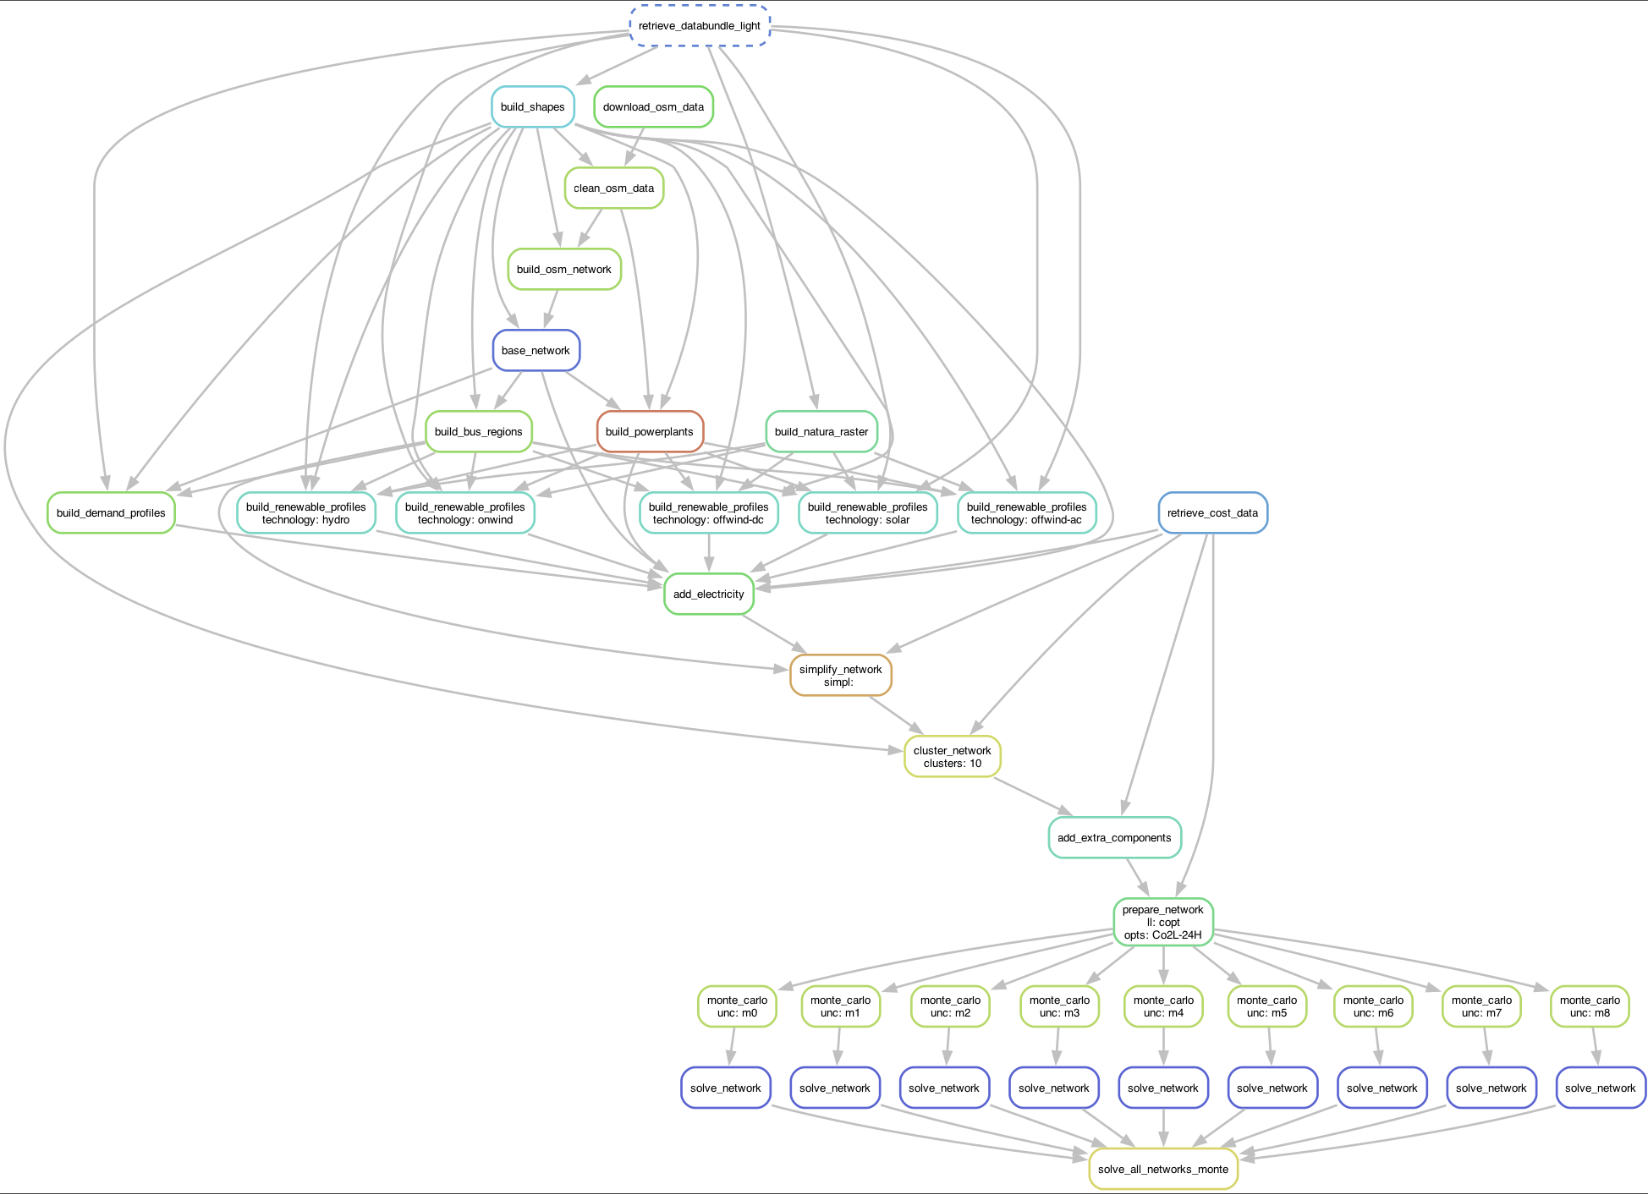

To run the workflow with a dryrun after activating the option in `config.yaml` file, run `snakemake -j1 solve_all_networks_monte -n`. To run the workflow without the dryrun, you can remove the `-n` option from the command.


After running the Monte-Carlo simulation, you should have a list of solved monte-carlo networks in the the results folder.

#### Loading Neccessary Libraries

In [1]:
import os
import pypsa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import logging
import yaml
    
import warnings
warnings.filterwarnings('ignore')

logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)

pd.set_option('display.max_columns', 500)

/Users/gbotemi/miniconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning: The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 
  warnings.warn(


In [2]:
# load the config file used for the monte carlo simulation
with open("config.yaml", "r") as stream:
    config = yaml.safe_load(stream)["monte_carlo"]

In [3]:
# load solved networks into a list
network_list = []

for count in range(0,49):
    # set directory of solved networks in results folder
    path = f"results/NG/networks/elec_s_10_ec_lcopt_Co2L-24H_m{count}.nc"
    network = pypsa.Network(path)
    network_list.append(network)

print("All Networks loaded successfully")

All Networks loaded successfully


In [4]:
# load network objective values
network_obejective_list = []

for idx in network_list:
    obj = idx.objective / 1e9
    network_obejective_list.append(obj)

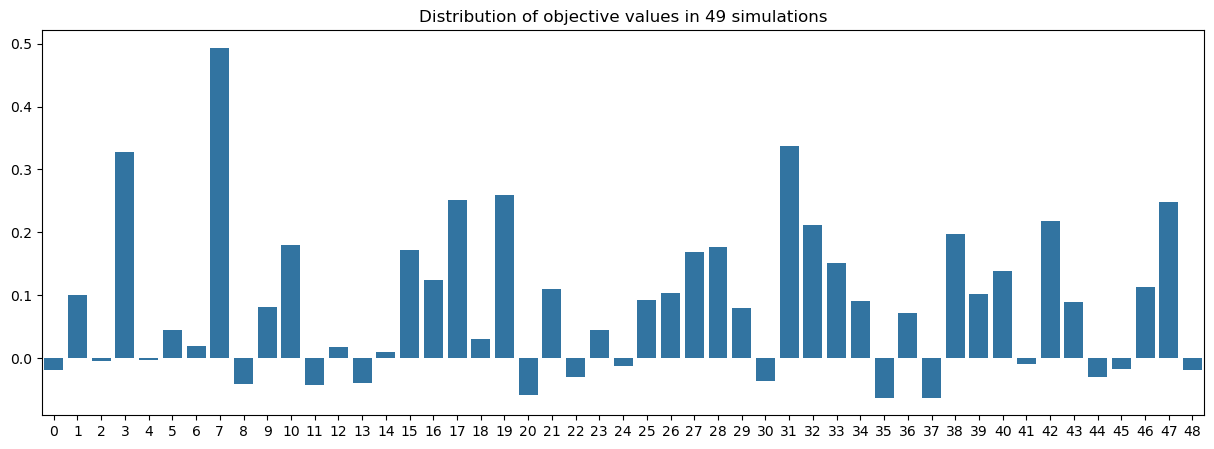

In [5]:
plt.figure(figsize=(15,5))
sns.barplot(network_obejective_list)
plt.title("Distribution of objective values in 49 simulations")
plt.show()

## Producing the post-processed coefficients from the solved networks

In [6]:
def verify_distribution(network_list: list, column_name: str) -> None:
    """
    Verify the distribution of chosen parameter applied for the monte-carlo simulation in the network list

    Parameters
        network_list: list of networks
        column_name: name of the column to be verified
    
    Returns
        None
    """
    component_list = []

    for idx in range(len(network_list)):
        component = eval(("network_list[idx]" + "." + column_name + ".sum().sum()").replace("n.", "network_list[idx]."))
        component_list.append(component)

    sorted(component_list)
    return component_list

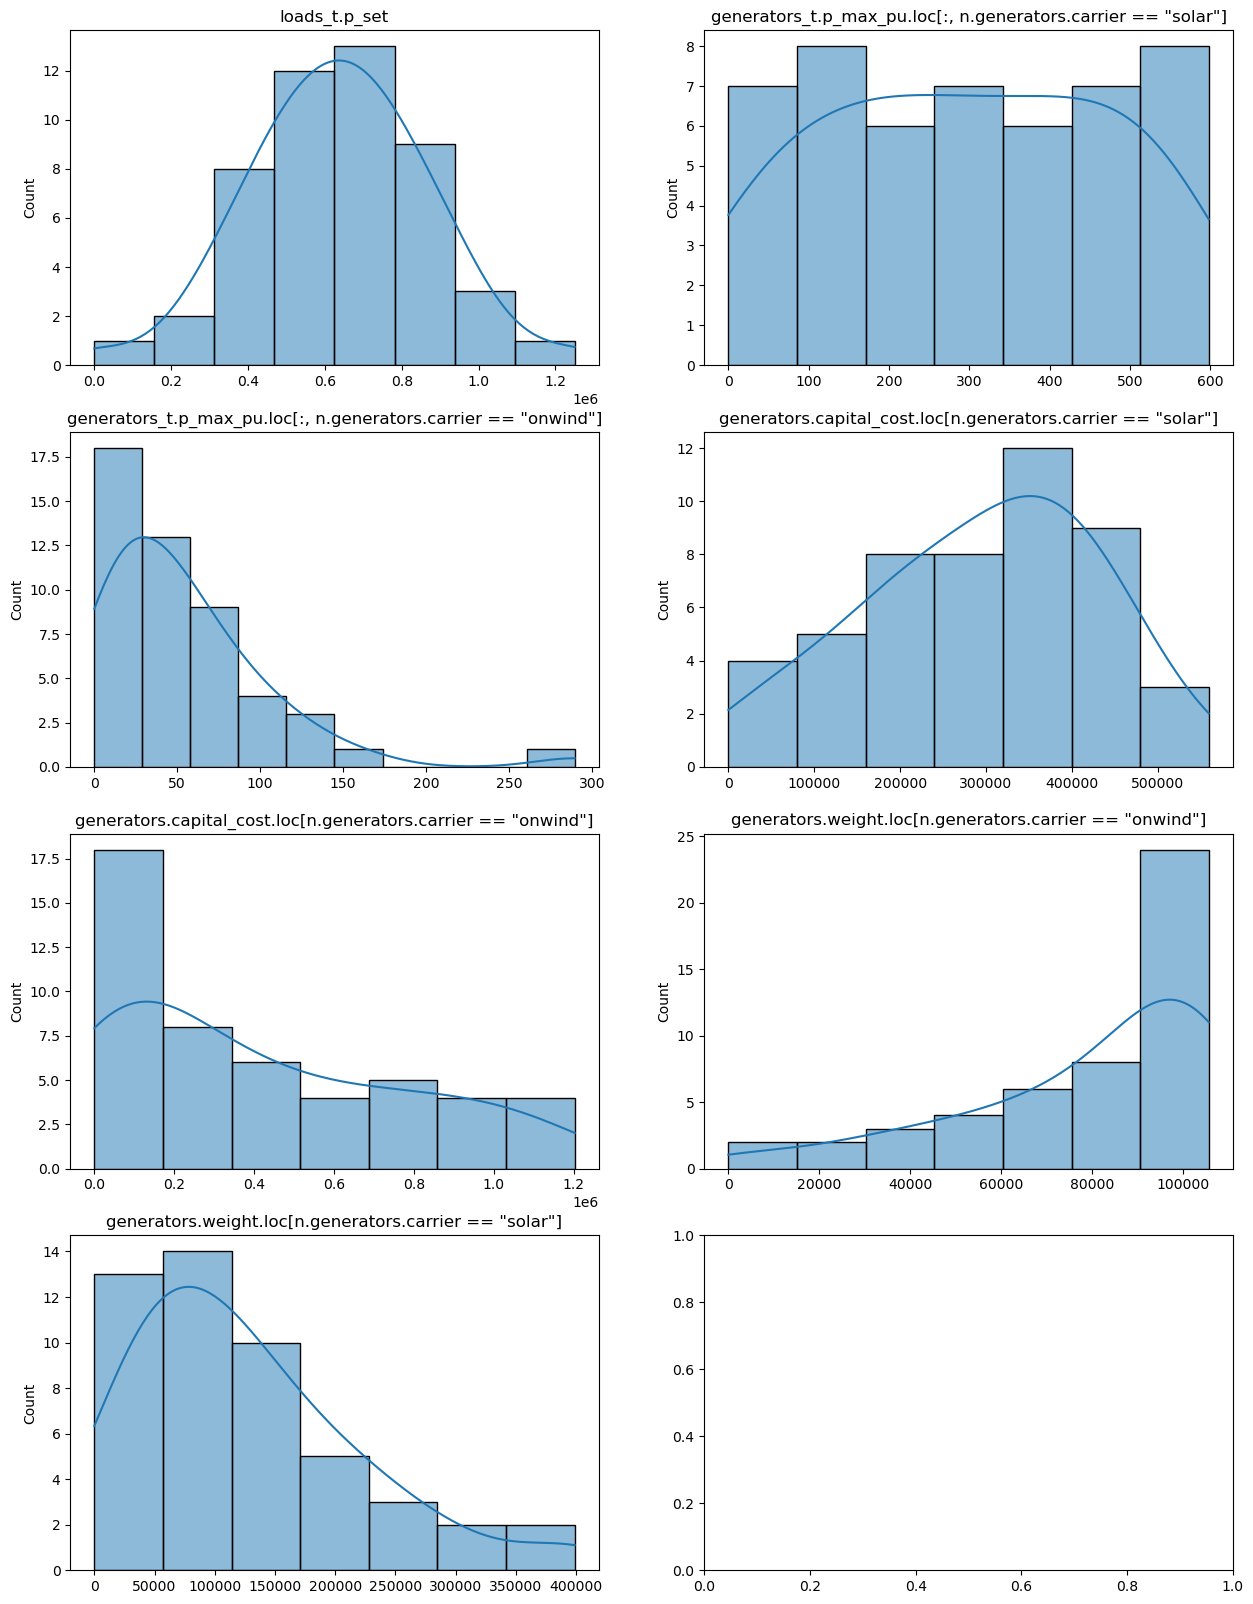

In [7]:
fig, axes = plt.subplots(4, 2, figsize=(15, 20), sharey=False)

for idx, p in enumerate(config["uncertainties"].keys()): 
	comp_list = verify_distribution(network_list, p)
	sns.histplot(comp_list, kde=True, ax=axes.flatten()[idx])
	axes.flatten()[idx].set_title(p)

This notebook has successfully equipped you with how to get started with the Monte-Carlo method in pypsa-earth. To perform a sensitivity analysis with the Monte-Carlo simulated networks, check `monte_carlo_case_study_nigeria_data` notebook